In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
recon = np.load('reconstructed_array_elbo.npy')
ground = np.load('ground_truth_elbo.npy')

### Pick your example to plot

#### This will calculate where the padding starts

In [3]:
example = 10

mask = ground[example][0] != 0
sum_result = np.sum(mask, axis=1)
start_of_padding = sum_result[0]+1

##### Here we are extracting the examples defined above

In [4]:
ground_truth_example = ground[example][0][:start_of_padding,:start_of_padding]
recon_example = recon[example][0][:start_of_padding,:start_of_padding]

# Make the diagonal 0s in reconstructed matrix because we don't calculate loss on these in VAE
np.fill_diagonal(recon_example, 0)

In [5]:
upper_triangle = np.triu(recon_example)
recon_example = upper_triangle + upper_triangle.T
np.fill_diagonal(recon_example, 0)

In [6]:
# Mean error of the reconstructed matrix
np.sqrt(((ground_truth_example - recon_example)**2).mean())

16.509575

#### Plot the ground truth, reconstructed map, and difference between the two

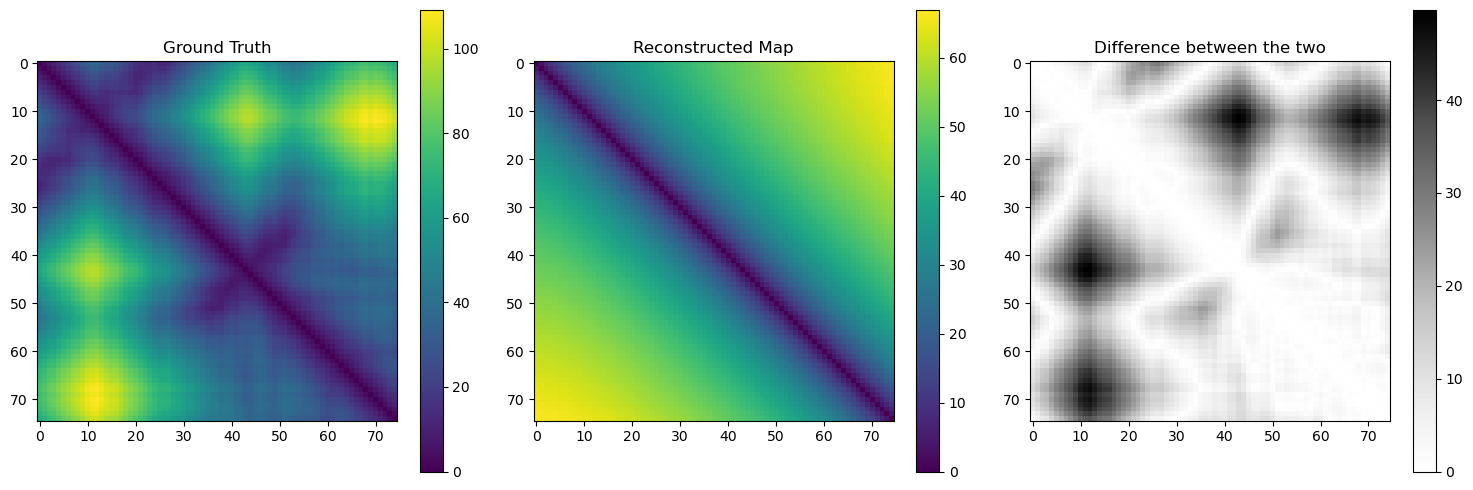

In [7]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot data1 in the first subplot
gt = axes[0].imshow(ground_truth_example, cmap='viridis')
axes[0].set_title('Ground Truth')
fig.colorbar(gt, ax=axes[0])

# Plot data2 in the second subplot
reconstructed = axes[1].imshow(recon_example, cmap='viridis')
axes[1].set_title('Reconstructed Map')
fig.colorbar(reconstructed, ax=axes[1])

# Plot data3 in the third subplot
difference = axes[2].imshow(abs(ground_truth_example - recon_example), cmap='Greys')
axes[2].set_title('Difference between the two')
fig.colorbar(difference, ax=axes[2])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

# Show the plots
plt.show()

#### Make a contact map out of the distance maps

In [53]:
contact_distance = 20

recon_contact_map = np.where(recon_example < contact_distance, 1, 0)
ground_truth_contact_map = np.where(ground_truth_example < contact_distance, 1, 0)

# Remove the diagonal elements
np.fill_diagonal(recon_contact_map,0)
np.fill_diagonal(ground_truth_contact_map,0)

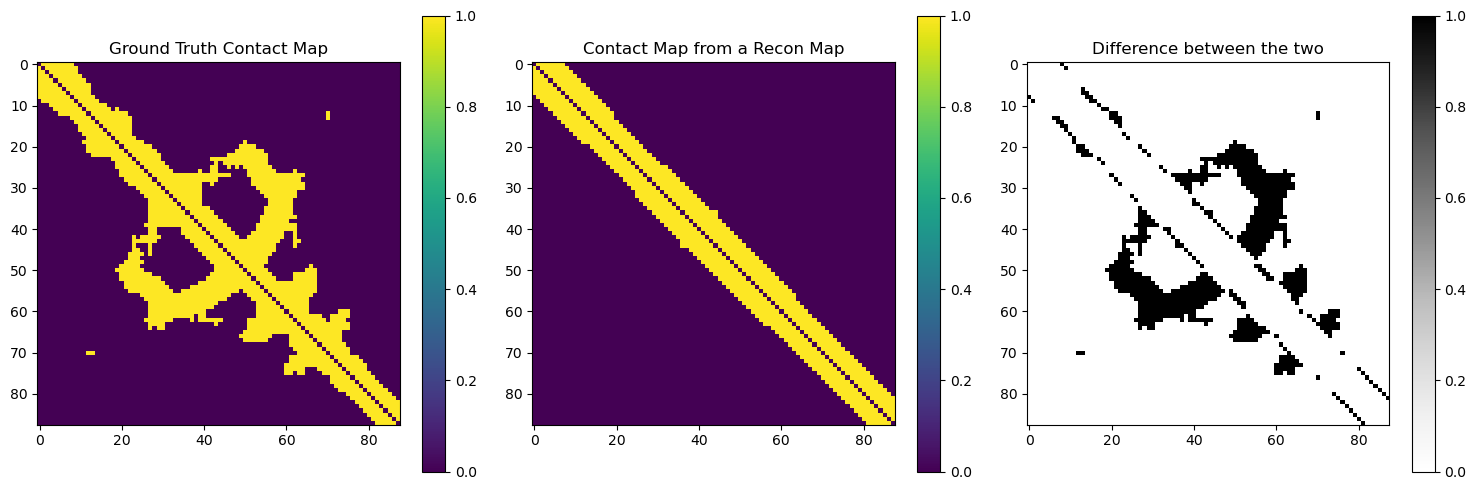

In [54]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot data1 in the first subplot
gt = axes[0].imshow(ground_truth_contact_map, cmap='viridis')
axes[0].set_title('Ground Truth Contact Map')
fig.colorbar(gt, ax=axes[0])

# Plot data2 in the second subplot
reconstructed = axes[1].imshow(recon_contact_map, cmap='viridis')
axes[1].set_title('Contact Map from a Recon Map')
fig.colorbar(reconstructed, ax=axes[1])

# Plot data3 in the third subplot
difference = axes[2].imshow(abs(ground_truth_contact_map - recon_contact_map), cmap='Greys')
axes[2].set_title('Difference between the two')
fig.colorbar(difference, ax=axes[2])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

# Show the plots
plt.show()

In [55]:
difference = np.abs(ground_truth_example - recon_example)

indices = np.where(difference==difference.max())

print(f'Largest deviation from ground truth {difference.max():.4f}A between bead {indices[0][0]} and {indices[1][0]}')

Largest deviation from ground truth 29.2934A between bead 1 and 31


## Reconstruction error of bond lengths

In [8]:
bond_length_errors = np.abs([ground_truth_example[i,i+1] - recon_example[i,i+1] for i in range(start_of_padding-1)])
mean_error = bond_length_errors.mean()
max_error = bond_length_errors.max()

print(f'Mean error of bond length reconstruction: {mean_error:.4f}A')
print(f'Max error of bond length reconstruction: {max_error:.4f}A')

Mean error of bond length reconstruction: 0.2476A
Max error of bond length reconstruction: 0.3750A


## Are there any beads that are clashing with other beads?

In [57]:
clash_distance = 6.27

clash_mask = np.where(recon_example < clash_distance, 1, 0)

# Remove the diagonal elements
np.fill_diagonal(clash_mask,0)

# Remove off-diagonal elements one position below the main diagonal
np.fill_diagonal(clash_mask[1:], 0) 

# Remove off-diagonal elements one position above the main diagonal
np.fill_diagonal(clash_mask[:,1:], 0)

print(f'Number of clashing beads: {clash_mask.sum()/2}')

Number of clashing beads: 0.0


#### Plot where the clash is

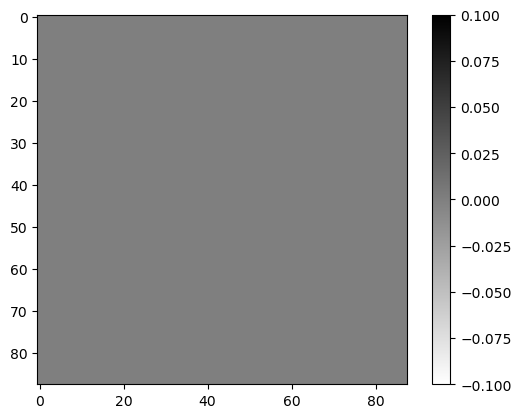

In [58]:
plt.imshow(clash_mask,cmap='binary')
plt.colorbar()

#### What is the distribution of error

In [45]:
start = 3
end = 5
stride = end-start

num_bins = int((ground_truth_example.max()-start)/stride)

mean_errors = []
max_errors = []

labels = []


for i in range(num_bins):
    ground_mask = np.where((start < ground_truth_example) & (ground_truth_example < end), 1, 0)
    ground_truth_distances = ground_truth_example * ground_mask
    recon_distances = recon_example * ground_mask
    absolute_difference = abs(ground_truth_distances-recon_distances)
    mean_absolute_difference = absolute_difference.sum()/np.count_nonzero(absolute_difference)
    max_errors.append(absolute_difference.max())
    mean_errors.append(mean_absolute_difference)
    labels.append(end)
    
    start += stride
    end += stride


Text(0, 0.5, 'Error in Angstrom')

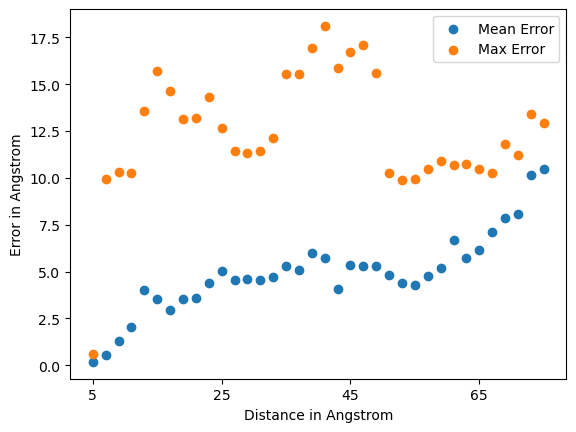

In [46]:
plt.scatter(range(len(mean_errors)),mean_errors, label='Mean Error')
plt.scatter(range(len(max_errors)),max_errors, label='Max Error')
plt.xticks(range(len(mean_errors))[::10], labels[::10])
plt.legend()

plt.xlabel('Distance in Angstrom')
plt.ylabel('Error in Angstrom')

Text(0, 0.5, 'Error in Angstrom')

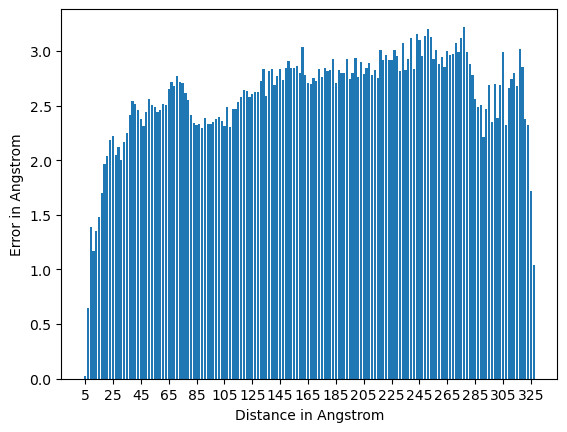

In [67]:
plt.bar(range(len(mean_errors)),mean_errors)
plt.xticks(range(len(mean_errors))[::10], labels[::10])

plt.xlabel('Distance in Angstrom')
plt.ylabel('Error in Angstrom')

In [67]:
import numpy as np

import numpy as np

def inverse_distance_weight(distances, max_distance, min_weight=0, max_weight=1):
    """
    Calculate weights based on inverse distances in a 2D space.

    Parameters:
    - distances (numpy array): Array of distances.
    - max_distance (float): Maximum distance.
    - min_weight (float, optional): Minimum weight (default is 0).
    - max_weight (float, optional): Maximum weight (default is 1).

    Returns:
    - weights (numpy array): Calculated weights.
    """
    inverse_distances = 1 / distances
    inverse_distances[np.isinf(inverse_distances)] = 0
    inverse_max_distance = np.max(inverse_distances)
    slope = (max_weight - min_weight) / inverse_max_distance
    weights = slope * inverse_distances + min_weight
    return weights

# Example usage
# Assuming distances is a 2D array where each row represents the distances from a point to all other points
# distances[i, j] represents the distance between point i and point j
distances = ground_truth_example

# Calculate the maximum distance
max_distance = np.max(distances)

# Calculate weights based on inverse distances
weights = inverse_distance_weight(distances, max_distance)

print(weights)

[[0.         0.9999962  0.5171191  ... 0.01225857 0.01233755 0.01245056]
 [0.9999962  0.         0.9999962  ... 0.01233063 0.01240913 0.01252245]
 [0.5171191  0.9999962  0.         ... 0.01246001 0.01253926 0.01265437]
 ...
 [0.01225857 0.01233063 0.01246001 ... 0.         0.99999547 0.5257166 ]
 [0.01233755 0.01240913 0.01253926 ... 0.99999547 0.         0.99999845]
 [0.01245056 0.01252245 0.01265437 ... 0.5257166  0.99999845 0.        ]]


/tmp/ipykernel_3607558/1819979066.py:18: RuntimeWarning: divide by zero encountered in divide
  inverse_distances = 1 / distances


In [65]:
weights = weights/(weights.sum()/2)

In [168]:
weights_reciprocal = 1/ground_truth_example
weights_reciprocal[np.isinf(weights_reciprocal)] = 0

weights_reciprocal = weights_reciprocal/(weights_reciprocal.sum())

/tmp/ipykernel_3607558/2260560543.py:1: RuntimeWarning: divide by zero encountered in divide
  weights_reciprocal = 1/ground_truth_example


In [169]:
weights_reciprocal_wrong = 1/ground_truth_example
weights_reciprocal_wrong[np.isinf(weights_reciprocal_wrong)] = 0

weights_reciprocal_squared = weights_reciprocal_wrong/(weights_reciprocal_wrong.sum()/2)

/tmp/ipykernel_3607558/2459386844.py:1: RuntimeWarning: divide by zero encountered in divide
  weights_reciprocal_wrong = 1/ground_truth_example


In [170]:
weights_reciprocal_squared = 1/ground_truth_example**2
weights_reciprocal_squared[np.isinf(weights_reciprocal_squared)] = 0

weights_reciprocal_squared = weights_reciprocal_squared/(weights_reciprocal_squared.sum())

/tmp/ipykernel_3607558/458540786.py:1: RuntimeWarning: divide by zero encountered in divide
  weights_reciprocal_squared = 1/ground_truth_example**2


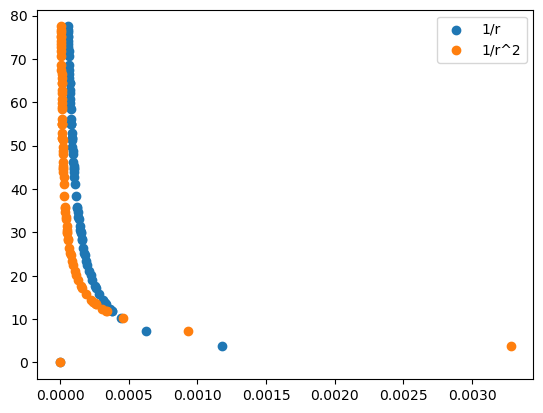

In [173]:
plt.scatter(weights_reciprocal[0], ground_truth_example[0], label='1/r')
plt.scatter(weights_reciprocal_squared[0], ground_truth_example[0], label='1/r^2')
plt.legend()
# plt.scatter(weights[0], ground_truth_example[0])

In [89]:
data = np.random.rand(100, 100)
target = np.random.rand(100, 100)

In [90]:
mse = np.mean((data-target)**2)

In [91]:
mse

0.16723325642657047

In [101]:
weights = np.ones((100,100))

In [102]:
squared_diffs = (data-target)**2
((squared_diffs*weights)/weights.sum()).sum()

0.16723325642657047

In [116]:
test = np.linspace(1,100,100)

In [146]:
max_distance = ground_truth_example.max()
min_distance = ground_truth_example.min()
weights = 1 - (ground_truth_example-min_distance)/(max_distance-min_distance)
np.fill_diagonal(weights,0)
weights = weights/weights.sum()

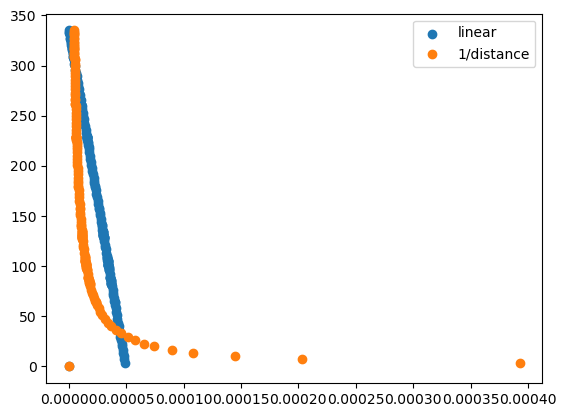

In [147]:
plt.scatter(weights[0],ground_truth_example[0], label='linear')
plt.scatter(weights_reciprocal[0], ground_truth_example[0], label='1/distance')
plt.legend()

In [174]:
weights.sum()

1.0

#### Analyze generated distances by sampling from N(0,I)

In [100]:
sampled_distance_maps = np.concatenate([np.load(i) for i in ['distance_map_batch_0.npy', 'distance_map_last_batch.npy']], axis=0)
sampled_distance_maps = sampled_distance_maps.reshape(1000,1,192,192)

In [83]:
example = 344

sampled_example = sampled_distance_maps[example][0]

upper_triangle = np.triu(sampled_example)
sampled_example = upper_triangle + upper_triangle.T
np.fill_diagonal(sampled_example, 0)

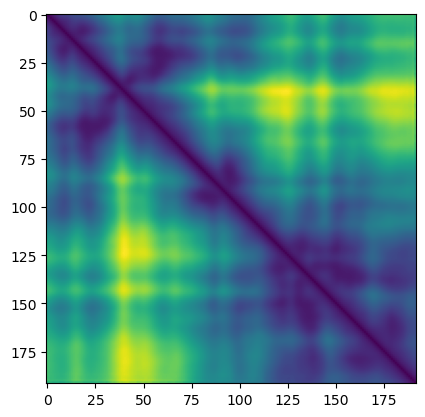

In [84]:
plt.imshow(sampled_example)

In [101]:
end_to_end_distance = [distance[0,-1] for distance in sampled_distance_maps[:,0]]

(array([ 32.,  97., 195., 247., 191., 122.,  82.,  25.,   5.,   4.]),
 array([ 36.1155014 ,  55.75260544,  75.38970947,  95.02681732,
        114.66392517, 134.30102539, 153.93814087, 173.57524109,
        193.21234131, 212.84945679, 232.48655701]),
 <BarContainer object of 10 artists>)

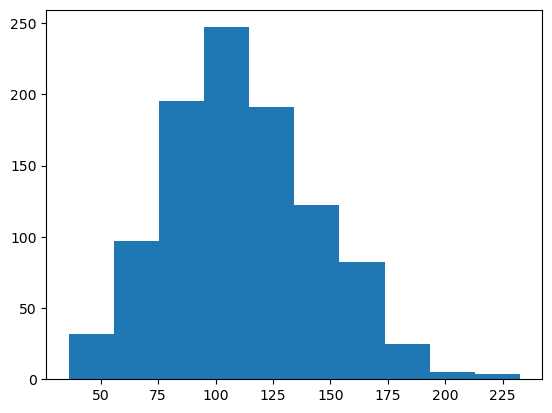

In [102]:
plt.hist(end_to_end_distance)

In [103]:
average_distance_map = np.mean(sampled_distance_maps, axis=0)[0]

upper_triangle = np.triu(average_distance_map)
average_distance_map = upper_triangle + upper_triangle.T
np.fill_diagonal(average_distance_map, 0)

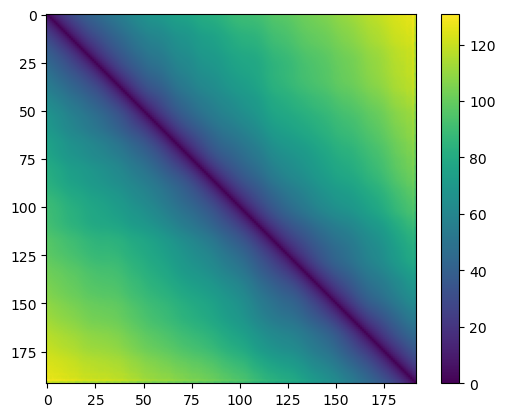

In [104]:
plt.imshow(average_distance_map)
plt.colorbar()

In [64]:
np.max(average_distance_map)

129.01848

In [74]:
import glob

files = glob.glob('/home/bnovak/projects/VAE_training/random_walk_pretraining/192/*gz')

In [75]:
ground_truth = [np.loadtxt(i) for i in files]

In [76]:
average_truth = np.mean(ground_truth,axis=0)

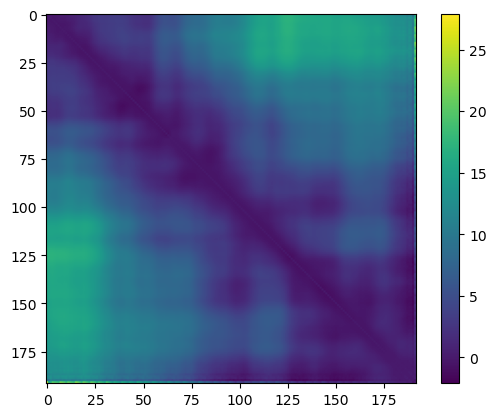

In [105]:
plt.imshow(average_truth-average_distance_map)
plt.colorbar()

In [68]:
from afrc import AnalyticalFRC

In [69]:
protein = AnalyticalFRC('G'*192)

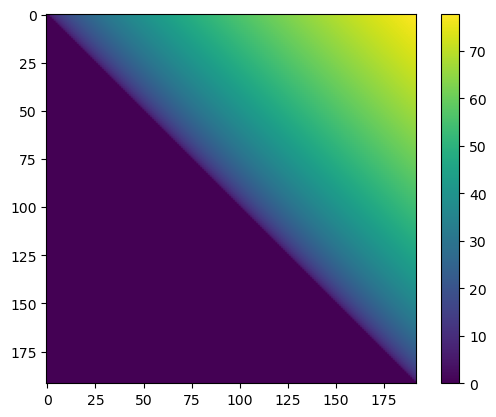

In [72]:
plt.imshow(protein.get_distance_map())
plt.colorbar()